# Spiking neural networks
Artificial neural networks (ANNs) form a central building block of Artificial Intelligence (AI). Initially, these networks were very loosely inspired by biology, capturing biological neural networks in a highly abstract way. Over time, various _generations_ of neural networks have been proposed [1]. The first generation of networks was based on McCulloch-Pitts neurons and only allowed for thresholded outputs, whereas the second generation featured continuous outputs by means of activation functions such as the sigmoid activation function. This allowed for continuous outputs. These types of ANNs have substantially evolved over time, progressively complexifying in terms of structure leading to the big successes in "deep learning". 

There is a third generation of neural networks that are termed _spiking neural networks_ (SNNs) [1]. These networks capture the temporal dynamics of biological neurons in more detail, and capture the fact that many neurons in the biological nervous system transmit information via electrical pulses termed "spikes". Recently, there is an increasing interest in these networks, since there are new processors that allow the implementation of SNNs leading to extremely fast and energy efficient neural computation. An example of such a processor is the Intel Loihi neuromorphic chip [2]. Neuromorphic processing holds the potential to provide advanced neural processing capabilities to edge devices such as mobile phones or small robots like lightweight drones.

In this notebook, you will familiarize yourself with some of the basic concepts of SNNs.

## Spiking neuron models
There are many different spiking neuron models, see, e.g., <A HREF="https://en.wikipedia.org/wiki/Biological_neuron_model" TARGET="_blank">this page on Wikipedia</A>. Here, we will first introduce to you a straightforward and often used model for SNNs, i.e., the _Leaky Integrate and Fire_ model (LIF model). It is an electrical input–output membrane voltage model, which captures the integration of incoming spikes into the membrane voltage, the leakage of this voltage over time in the absence of incoming spikes, and the firing of a spike that happens when the voltage supercedes a threshold. The model is formulated mathematically as follows:

$$ C \frac{\partial V(t)}{\partial t} = I(t) - \frac{V(t)}{R} $$

, where $C$ represents the capacitance, $V(t)$ the voltage of the membrane, $I(t)$ the input current, and $R$ the membrane resistance. Not captured in this formula itself is that if the voltage supercedes a threshold, a spike is emitted and the voltage is reset to the resting voltage, typically $V_{\textrm{rest}} = 0$.

Below, we give the code for a LIF neural model, implemented in <A HREF="https://pytorch.org/" TARGET="_blank">PyTorch</A>. If you're not familiar with PyTorch, we recommend following <A HREF="https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html" TARGET="_blank">this short 60-minute introduction to PyTorch</A>. Or, if that is too long, you can simply consider that tensors are generalized matrices (of any dimension), and their use is very similar to that of arrays in ``numpy`` (see <A HREF="https://medium.com/@quantumsteinke/whats-the-difference-between-a-matrix-and-a-tensor-4505fbdc576c" TARGET="_blank">here</A> for a more detailed explanation). Moreover, the code is decorated to indicate the types of, e.g., input and output arguments, using the <A HREF="https://docs.python.org/3/library/typing.html" TARGET="_blank">typing module</A>.

In [27]:
# Code in this notebook has been made by Jesse Hagenaars, with (minor) adaptations by Guido de Croon.

from typing import Optional, NamedTuple, Tuple

import torch
import numpy as np
import matplotlib.pyplot as plt

def spike_function(v_thresh: torch.Tensor) -> torch.Tensor:
    return v_thresh.gt(0.0).float()  # gt means greater than, which works on tensors

# Placeholder for LIF state
class LIFState(NamedTuple):
    z: torch.Tensor
    v: torch.Tensor
    i: torch.Tensor

# Placeholder for LIF parameters
class LIFParameters(NamedTuple):
    i_decay: torch.Tensor = torch.as_tensor(0.0)
    v_decay: torch.Tensor = torch.as_tensor(0.75)
    thresh: torch.Tensor = torch.as_tensor(0.5)

# Actual LIF function
def lif_neuron(
    i: torch.Tensor,
    state: Optional[LIFState] = None,
    p: LIFParameters = LIFParameters(),
) -> Tuple[torch.Tensor, LIFState]:
    # Previous state
    if state is None:
        # if no state, initialize to zeros:
        state = LIFState(
            z=torch.zeros_like(i),
            v=torch.zeros_like(i),
            i=torch.zeros_like(i),
        )
    # Update state
    i = state.i * p.i_decay + i
    # Update the membrane voltage. Note that multiplying with (1.0 - state.z) resets the voltage to 0 after a spike
    v = state.v * p.v_decay * (1.0 - state.z) + i
    # Spike if the voltage is larger than a threshold
    z = spike_function(v - p.thresh)
    
    return z, LIFState(z, v, i)


<FONT color="red">Exercise 1.</FONT>

1. Study the code above. Is there a difference between the code and the LIF model as given in the formula?

2. Run the code below. It generates an input spike train, and simulates the LIF neuron. Make code to count the number of spikes in the simulated time span. How many spikes are generated by the given code? And what is the maximal number of spikes you can get in 100 time steps by changing the input spike train?

3. What happens if you enter a constant input current of 0.10? What LIF parameter(s) can be changed so that the observed phenomenon changes?

4. An even simpler model is called the "perfect integrate and fire model" or "non-leaky integrate and fire model", in which it is assumed that the resistance $R \rightarrow \infty$ in the formula of the LIF model. What parameter would have to be changed in the code and how to represent this NLIF model?

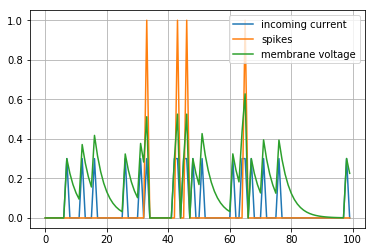

Number of spikes = 4.0


In [33]:
steps = 100
constant_current = False

if not constant_current:
    # create an input spike train with 1 out of 5 time steps a spike multiplied with a fixed input weight
    input_weight = 0.3
    i = torch.randint(5, (steps,)).eq(0).float() * input_weight
else:
    # create a constant input current
    i = torch.ones((steps,)) * 0.10

currents = []
states = []
state = None
for step in range(steps):
    _, state = lif_neuron(i[step], state)
    currents.append(i[step].item())  # .item() to convert tensor to float (for 1-element tensor)
    states.append([state.z.item(), state.v.item(), state.i.item()])
    
plt.plot(currents, label="incoming current")
plt.plot(np.array(states)[:, 0], label="spikes")
plt.plot(np.array(states)[:, 1], label="membrane voltage")
#plt.plot(np.array(states)[:, 2], label="input current")

plt.grid()
plt.legend()
plt.show()

## Answers

<FONT color="red">Exercise 1.</FONT>

1. The code also has a decay rate for the input current. However, since the parameter ``i_decay`` is equal to 0, it does not make a difference from the stated LIF model.

2. The spikes can be counted with the code below. Typically, 3-6 spikes are generated with the default code. Selecting the constant input option and changing the input current to 1.0 will generate a constant output spike, so 100 spikes per 100 time steps. The current model does not have a refractory period as present in biological neurons.

In [ ]:
spikes = np.array(states)[:, 0]
print(f'Number of spikes = {np.sum(spikes)}')

3. Given the default parameters, the neuron never spikes. The "leak" is too large. You can either increase the voltage decay factor so that membrane voltage decays less (e.g., to $0.95$) or lower the threshold (e.g., to $0.1$), in order to get spikes again. 

4. The parameter ``v_decay`` should be set to $1.0$.

## References
[1] Maass, W. (1997). Networks of spiking neurons: the third generation of neural network models. Neural networks, 10(9), 1659-1671.

[2] Davies, M., Srinivasa, N., Lin, T. H., Chinya, G., Cao, Y., Choday, S. H., ... & Wang, H. (2018). Loihi: A neuromorphic manycore processor with on-chip learning. Ieee Micro, 38(1), 82-99.